# Model Comparison

In this example you will learn how to compare different models with TruLens.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/truera/trulens/blob/main/trulens_eval/examples/expositional/models/model_comparison.ipynb)

## Setup
### Add API keys
For this quickstart you will need Open AI and Huggingface keys

In [19]:
import os
import replicate
from IPython.display import Image
import io
import requests

os.environ["REPLICATE_API_TOKEN"] = "..."

In [20]:
def image_generator(prompt):
    return replicate.run(
    "stability-ai/sdxl:c221b2b8ef527988fb59bf24a8b97c4561f1c671f73bd389f866bfb27c061316",
    input={"prompt": prompt}
)[0]

In [22]:
image = image_generator("Create a mockup dashboard for monitoring the quality of an AI application over time")

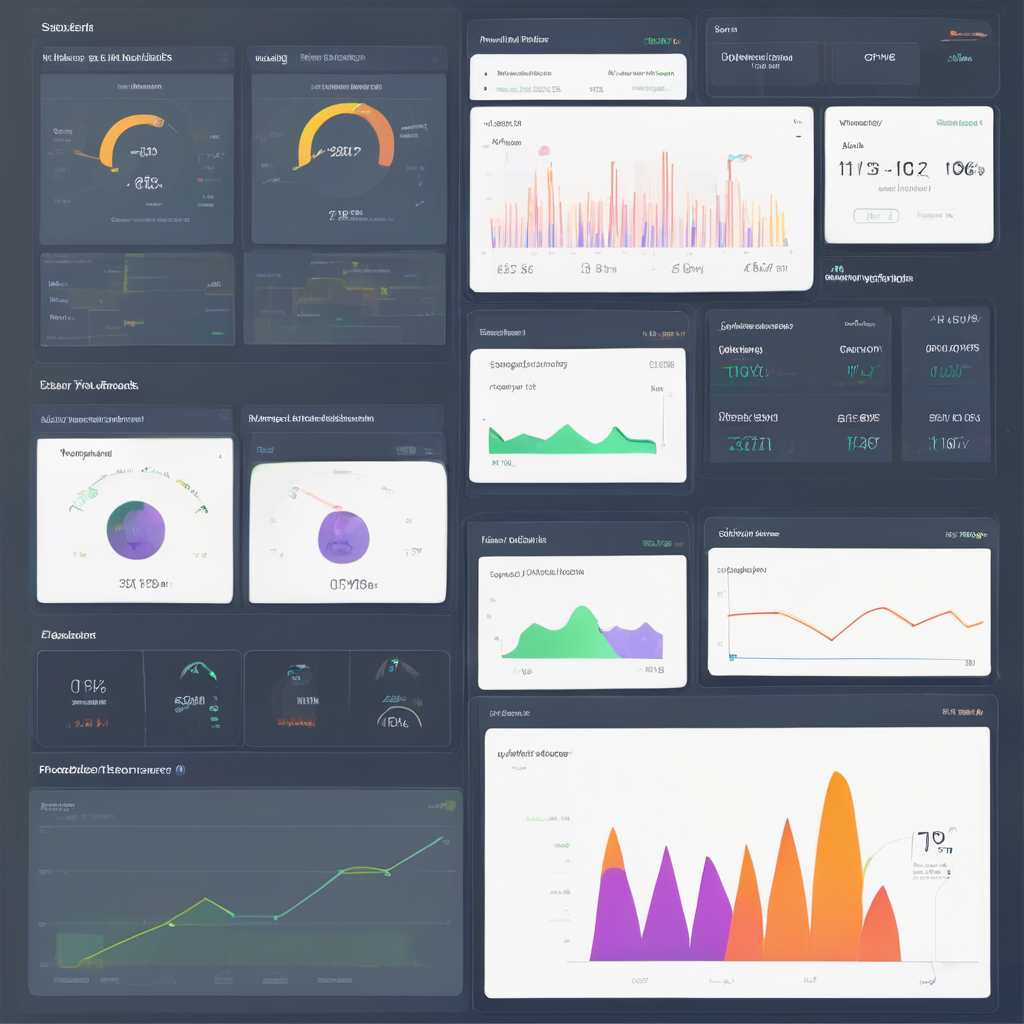

In [23]:
Image(image)

In [24]:
def eval_image(image_url, eval_prompt):
    response = requests.get(image_url)
    file_bytes = response.content

    file_like_object = io.BytesIO(file_bytes)

    output = replicate.run(
        "yorickvp/llava-13b:2facb4a474a0462c15041b78b1ad70952ea46b5ec6ad29583c0b29dbd4249591",
        input={"image": file_like_object, "prompt" : eval_prompt}
    )
    # The yorickvp/llava-13b model can stream output as it's running.
    # The predict method returns an iterator, and you can iterate over that output.
    for item in output:
        # https://replicate.com/yorickvp/llava-13b/versions/2facb4a474a0462c15041b78b1ad70952ea46b5ec6ad29583c0b29dbd4249591/api#output-schema
        print(item, end="")

In [27]:
eval_prompt = "Is all the text in the image human-readable in any language? Rate from 0 to 10 and explain why. Output a dict in the format {Score: SCORE, reason: 'REASON'}"

In [28]:
eval_image(image, eval_prompt)

{Score: 8, reason: 'The text in the image is in German, which is not human-readable for most people. However, the graphs and charts are universally understood, making it easy for people to interpret the data. The image is well-organized and visually appealing, which adds to its overall score.'}